In [1]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
from AutoEncoderCNN import AE_CNN
from GridSearch import GridSearch

In [2]:
# hyperparams and early stopping patience
EPOCHS = [100, 500, 1000]
LR = [0.001, 0.0001]
WEIGHT_DECAY = [1e-5]
BATCH_SIZE = [4, 8]
FIRST_DIM = [16,32,64]
ENCODE_DIM = [128,256,512]
patience = 30

# setting the correct device to train on
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# creating the grid search object
GS = GridSearch( 
       device,
       early_stop_depth = patience,
       epochs=EPOCHS,
       learning_rate=LR,
       weight_decay=WEIGHT_DECAY,
       batch_size = BATCH_SIZE,
       first_dim = FIRST_DIM,
       encode_dim = ENCODE_DIM,
       verbose = 1)

In [3]:
GS.search() # running grid search 
GS.save_dicts() # saving the info from GS

Starting search with 108 combinations and a early stopping patience of: 30

---Count: 0, Epochs: 100, Weight_Decay: 1e-05, Learning_Rate: 0.001, Batch_Size: 4, First Dim: 16, Encode Dim: 128---


Epoch: 1 | Loss: 0.2508


Epoch: 2 | Loss: 0.1125


Epoch: 3 | Loss: 0.1916


Epoch: 4 | Loss: 0.2870


Epoch: 5 | Loss: 0.1107


Epoch: 6 | Loss: 0.1773


Epoch: 7 | Loss: 0.1112


Epoch: 8 | Loss: 0.1873


Epoch: 9 | Loss: 0.0654


Epoch: 10 | Loss: 0.1570


Epoch: 11 | Loss: 0.1894


Epoch: 12 | Loss: 0.0986


Epoch: 13 | Loss: 0.1772


Epoch: 14 | Loss: 0.1616


Epoch: 15 | Loss: 0.1626


Epoch: 16 | Loss: 0.1424


Epoch: 17 | Loss: 0.1527


Epoch: 18 | Loss: 0.1399


Epoch: 19 | Loss: 0.1688


Epoch: 20 | Loss: 0.1455


Epoch: 21 | Loss: 0.1135


Epoch: 22 | Loss: 0.2194


Epoch: 23 | Loss: 0.1347


Epoch: 24 | Loss: 0.1123


Epoch: 25 | Loss: 0.1790


Epoch: 26 | Loss: 0.2129


Epoch: 27 | Loss: 0.1180


Epoch: 28 | Loss: 0.1326


Epoch: 29 | Loss: 0.1563


Epoch: 30 | Loss: 0.1202


Epo

KeyboardInterrupt: 

In [4]:
# creating and untrained model of the best dimensionality found by GS
model = AE_CNN(GS._best_dict["First Dim"], GS._best_dict["Encode Dim"]).to(device)

model.load_state_dict(torch.load('./models/model_gs.pth')) # loading best model state

# setting the encoder and decoder for visualization
encoder = model.encoder
decoder = model.decoder

In [5]:
# input and output arrays
auto_encoder_output = []
encoded_imgs_arr = []
decoded_imgs_arr = []
img_set = GS._test_set # test_set

for x in range(len(img_set)):
    with torch.no_grad():
        inp = img_set.__getitem__(x)[0].to(device)
        
        encoded_imgs = encoder(inp)
        encoded_imgs_arr.append(encoded_imgs)
        
        decoded_imgs = decoder(encoded_imgs)
        decoded_imgs_arr.append((inp, decoded_imgs))
        
        auto_encoder_output.append((inp, model(inp)))

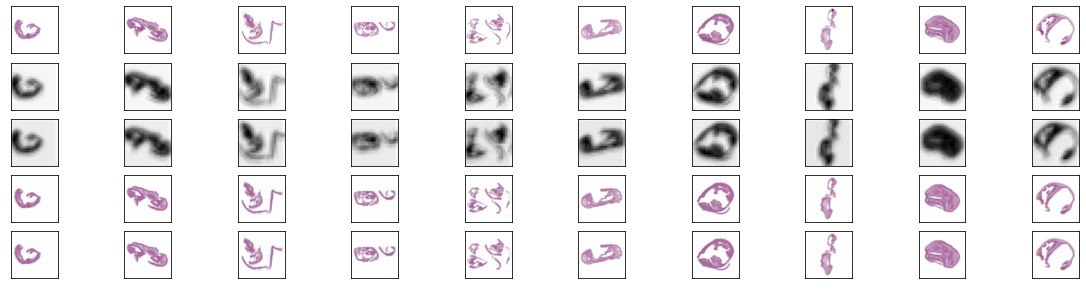

In [6]:
amt = 10
cols = 5
plt.figure(figsize=(20,cols))


for k in range(amt):
    
    # input image
    ax = plt.subplot(cols, amt, k+1)
    img = decoded_imgs_arr[k][0]
    img = img.detach().cpu().numpy()
    plt.imshow(np.transpose(img, (1,2,0))) # changes to rgb
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Compressed states
    ax = plt.subplot(cols,amt, k+1+amt)
    plt.gray()
    img = encoded_imgs_arr[k].detach().cpu().numpy()
    conv_filter = 0 # [0, 128)
    plt.imshow(np.transpose(img, (1,2,0))[:,:,conv_filter]) 
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(cols,amt, k+1+2*amt)
    plt.gray()
    conv_filter -= 50 # [0, 128)
    plt.imshow(np.transpose(img, (1,2,0))[:,:,conv_filter]) 
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Output States
    ax = plt.subplot(cols,amt, k+1+3*amt)
    recon = decoded_imgs_arr[k][1]
    recon = recon.detach().cpu().numpy()
    plt.imshow(np.transpose(recon, (1,2,0)))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(cols,amt, k+1+4*amt)
    recon = auto_encoder_output[k][1]
    recon = recon.detach().cpu().numpy()
    plt.imshow(np.transpose(recon, (1,2,0)))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)